# Taller 1- vision por computador SmartVision

notebook para el taller 1 de vision por computador SmartVision.

## Integrantes
- Johan Sebastian Cano Garcia
- Brayan Armando Cumbalaza Vallejo
- Laura Camila Agudelo Ospina
- Alejandro Esteban Munoz Osorio

## Librerias Utilizadas

In [1]:
# Importación de librerías necesarias para el procesamiento de imágenes y visualización de resultados
import cv2  # OpenCV para manejo de imágenes
import numpy as np  # Numpy para operaciones numéricas y matriciales
import matplotlib.pyplot as plt  # Matplotlib para visualización de imágenes y gráficos
import os
import glob
from PIL import Image
import imageio

In [2]:
# Definición del directorio base donde se encuentran las imágenes a utilizar
base_path = "../Images/"  # Ajustar la ruta según la ubicación real de las imágenes

## 1. Calibración de cámaras

La calibración de cámara es esencial para cualquier aplicación de visión que requiera mediciones precisas o reconstrucción 3D. Permite:
- Corregir distorsiones de lente
- Establecer la relación entre coordenadas del mundo real y píxeles
- Obtener parámetros intrínsecos (matriz K, coeficientes de distorsión)

Este enlace contiene una guía para calibrar imágenes https://classroom.google.com/c/NzgwMDM2NDYwMzA5/m/ODEwMDkzMTg1MTgy/details

Para el reporte, deben incluir:
- Mostrar 4-6 imágenes con las esquinas detectadas dibujadas
- Código: cv2.drawChessboardCorners()
- Matriz de cámara K:
$$
K = \begin{pmatrix}
fx & 0 & cx \\
0 & fy & cy \\
0 & 0 & 1
\end{pmatrix}
$$
- Coeficientes de distorsión: k1, k2, p1, p2, k3
- Error RMS de reproyección (debe ser < 0.5 píxeles para buena calibración)
- Mostrar al menos 3 imágenes originales vs. corregidas
- Evidenciar especialmente la corrección en las esquinas (donde la distorsión es mayor)
- ¿Qué tipo de distorsión predomina? (barril, cojín)
- ¿La longitud focal fx es similar a fy? ¿Por qué podría diferir?
- ¿El punto principal (cx, cy) está cerca del centro de la imagen?

In [2]:
# Define las dimensiones del tablero de ajedrez
CHECKERBOARD = (5, 8)


# Detener la iteración cuando se especifique
# se alcanza la precisión, épsilon, o
# se completa el número especificado de iteraciones.
criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


In [3]:
# Listas para almacenar los puntos
threedpoints = []  # puntos 3D en el mundo real
twodpoints = []    # puntos 2D en la imagen

#  3D points real world coordinates
objectp3d = np.zeros((1, CHECKERBOARD[0]
                      * CHECKERBOARD[1],
                      3), np.float32)
objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0],
                               0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

In [4]:
# Extrayendo la ruta de las imágenes individuales almacenadas
# en un directorio dado. Como no se especifica ninguna ruta,
# tomará solo los archivos .jpeg del directorio actual.
images = glob.glob('../Imagenes_calibracion/*.jpeg')

In [6]:
# Define la ruta de destino para guardar las imágenes
OUTPUT_PATH = '../Puntos_detectados/'
# Crea el directorio de salida si no existe
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print(f"Directorio creado para guardar imágenes detectadas: {OUTPUT_PATH}")

Directorio creado para guardar imágenes detectadas: ../Puntos_detectados/


Guardado: ../Puntos_detectados/detected_imagen1.jpeg
Guardado: ../Puntos_detectados/detected_imagen2.jpeg
Guardado: ../Puntos_detectados/detected_imagen3.jpeg
Guardado: ../Puntos_detectados/detected_imagen4.jpeg
Guardado: ../Puntos_detectados/detected_imagen5.jpeg
Guardado: ../Puntos_detectados/detected_imagen6.jpeg
Guardado: ../Puntos_detectados/detected_imagen7.jpeg


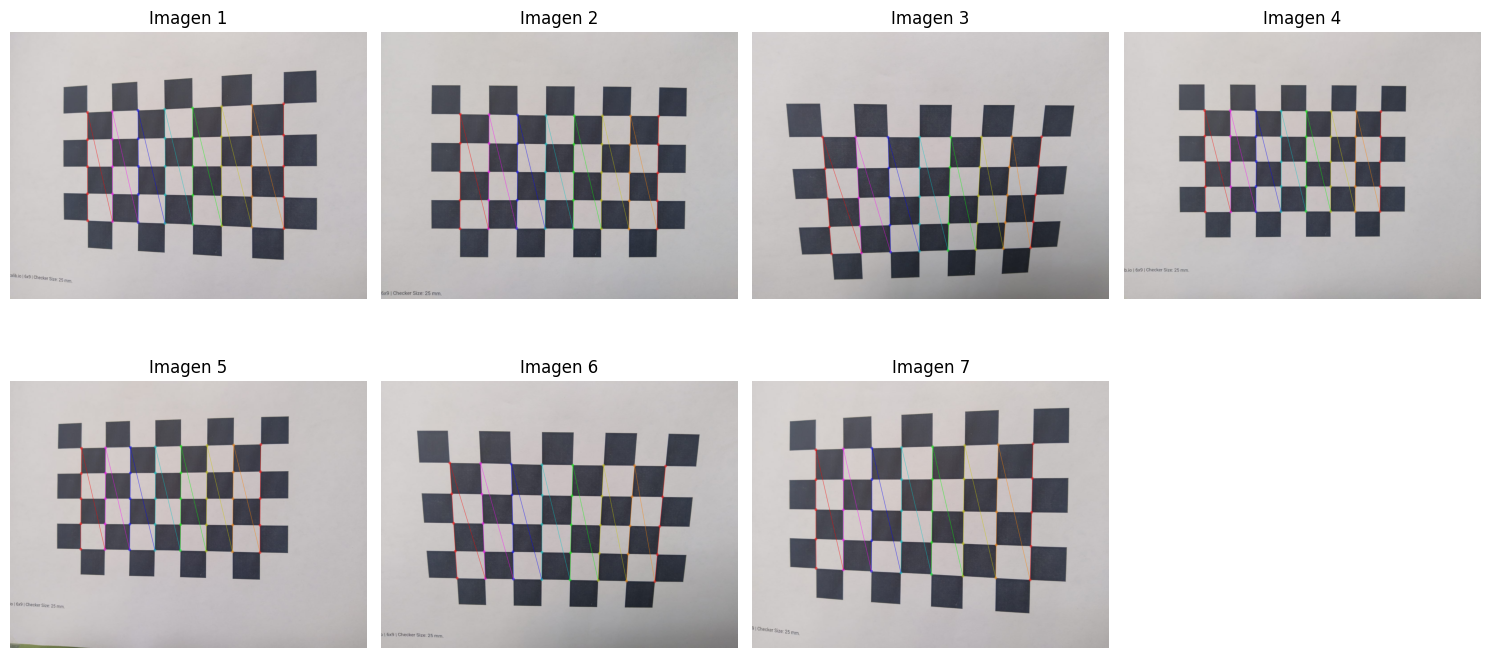

 Camera matrix:
[[1.34422582e+03 0.00000000e+00 8.01860348e+02]
 [0.00000000e+00 1.35076896e+03 6.13076116e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

 Distortion coefficient:
[[ 2.77117654e-01 -1.89487857e+00 -7.03569092e-05  5.67813997e-04
   4.13846062e+00]]

 Rotation Vectors:
(array([[0.173394  ],
       [0.16700156],
       [1.5627828 ]]), array([[-0.00279887],
       [-0.03297257],
       [ 1.57748416]]), array([[ 0.132116  ],
       [-0.26009193],
       [ 1.56139   ]]), array([[-0.00212568],
       [-0.04655433],
       [ 1.57232751]]), array([[0.08449755],
       [0.09002577],
       [1.57529355]]), array([[ 0.17692476],
       [-0.17287789],
       [ 1.5795949 ]]), array([[0.1744715 ],
       [0.12070526],
       [1.57892063]]))

 Translation Vectors:
(array([[ 3.05353278],
       [-2.05812265],
       [ 9.79994544]]), array([[ 3.50090269],
       [-1.82753868],
       [10.80282238]]), array([[ 3.62619948],
       [-1.02032342],
       [ 9.95746693]]), array([[ 3.

In [7]:
images_with_corners = [] # Lista para almacenar las imágenes con esquinas detectadas (para Matplotlib)


for filename in images:
    # Obtener solo el nombre del archivo (ej: 'img01.jpeg') incluso si 'filename' es '../Imagenes_calibracion/img01.jpeg'
    base_filename = os.path.basename(filename)
    image = cv2.imread(filename)
    # Convertir BGR a RGB para la visualización con Matplotlib
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    grayColor = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Buscar las esquinas del tablero de ajedrez (patrón de calibración)
    # Si se encuentra el número deseado de esquinas en la imagen, 'ret' será True
    ret, corners = cv2.findChessboardCorners(
                        grayColor, CHECKERBOARD, 
                        cv2.CALIB_CB_ADAPTIVE_THRESH 
                        + cv2.CALIB_CB_FAST_CHECK + 
                        cv2.CALIB_CB_NORMALIZE_IMAGE)

    # Si se puede detectar el número deseado de esquinas,
    # refinar las coordenadas de los píxeles y dibujarlas en la imagen
    if ret == True:
        # Añadir las coordenadas 3D (puntos del mundo real)
        threedpoints.append(objectp3d)

        # Refinar las coordenadas de píxeles
        # para los puntos 2D dados.
        corners2 = cv2.cornerSubPix(
            grayColor, corners, (11, 11), (-1, -1), criteria)

        # Añadir las coordenadas 2D (puntos de píxel)
        twodpoints.append(corners2)

        # Dibujar y mostrar las esquinas en la imagen
        image = cv2.drawChessboardCorners(image, 
                                            CHECKERBOARD, 
                                            corners2, ret)
        
        # Convertir BGR de nuevo a RGB para la visualización en el entorno Jupyter
        rgb_image_corners = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images_with_corners.append(rgb_image_corners) # Almacenar para ver luego


        # Guardar la imagen con las esquinas detectadas en la ruta de salida
        output_filepath = os.path.join(OUTPUT_PATH, f"detected_{base_filename}")
        cv2.imwrite(output_filepath, image)
        print(f"Guardado: {output_filepath}")
        
        
# OPCIONAL: Mostrar todas las imágenes con las esquinas dibujadas al final usando Matplotlib
if images_with_corners:
    num_images = len(images_with_corners)
    # Calcular el número de filas y columnas para el subplots
    cols = min(4, num_images) # Máximo 4 columnas, por ejemplo
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15 * rows / cols))
    axes = axes.flatten()
    
    for i, img_corners in enumerate(images_with_corners):
        axes[i].imshow(img_corners)
        axes[i].set_title(f"Imagen {i+1}")
        axes[i].axis('off')
        
    # Ocultar subplots no utilizados
    for j in range(num_images, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

# Asegurarse de que tenemos al menos una imagen para obtener la forma necesaria para la calibración
if 'image' in locals() and image is not None:
    h, w = image.shape[:2]
    # Realizar la calibración de la cámara pasando los valores de los puntos 3D (threedpoints)
    # y sus correspondientes coordenadas de píxeles 2D (twodpoints)
    ret, matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera(
        threedpoints, twodpoints, grayColor.shape[::-1], None, None) # Usamos grayColor.shape[::-1] para el tamaño de la imagen

    # Mostrar la salida requerida
    print(" Camera matrix:")
    print(matrix)
    print("\n Distortion coefficient:")
    print(distortion)
    print("\n Rotation Vectors:")
    print(r_vecs)
    print("\n Translation Vectors:")
    print(t_vecs)
    print("\n Error RMS global")
    print(ret)
else:
    print("No se encontraron imágenes o no se detectaron esquinas en ninguna imagen.")

Directorio creado para imágenes corregidas: ../Imagenes_corregidas/
Guardada imagen corregida: ../Imagenes_corregidas/undistorted_imagen1.jpeg


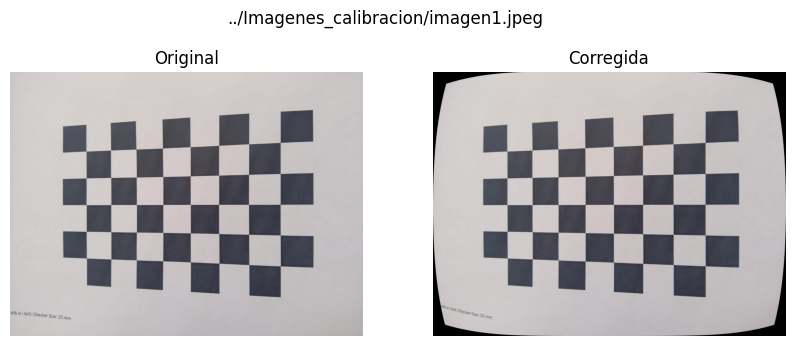

Guardada imagen corregida: ../Imagenes_corregidas/undistorted_imagen2.jpeg


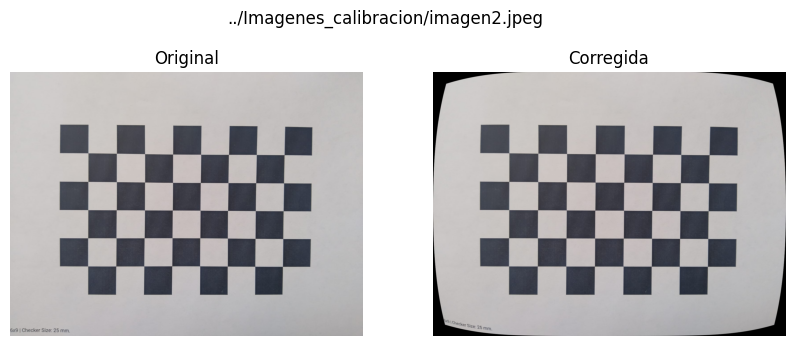

Guardada imagen corregida: ../Imagenes_corregidas/undistorted_imagen3.jpeg


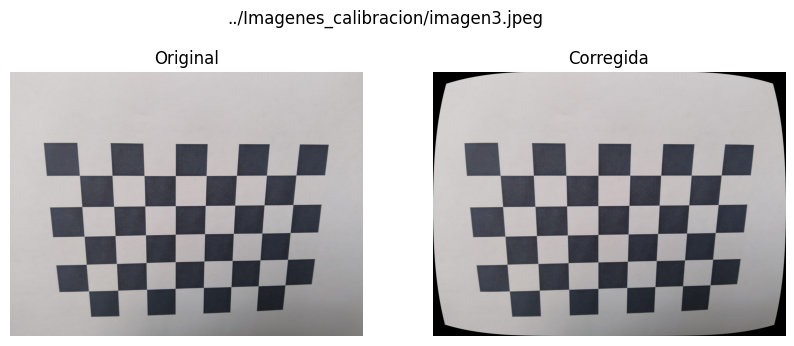

Guardada imagen corregida: ../Imagenes_corregidas/undistorted_imagen4.jpeg


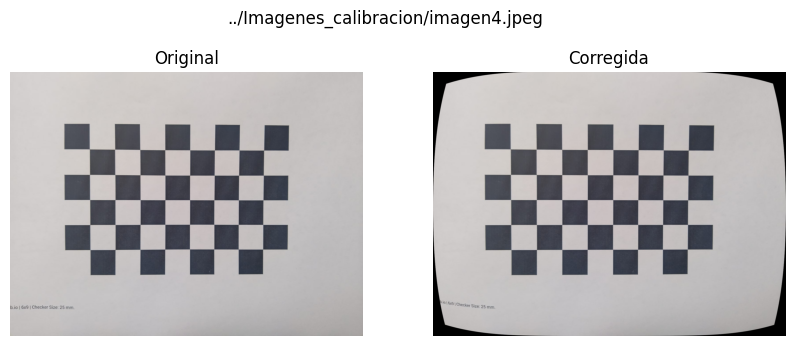

Guardada imagen corregida: ../Imagenes_corregidas/undistorted_imagen5.jpeg


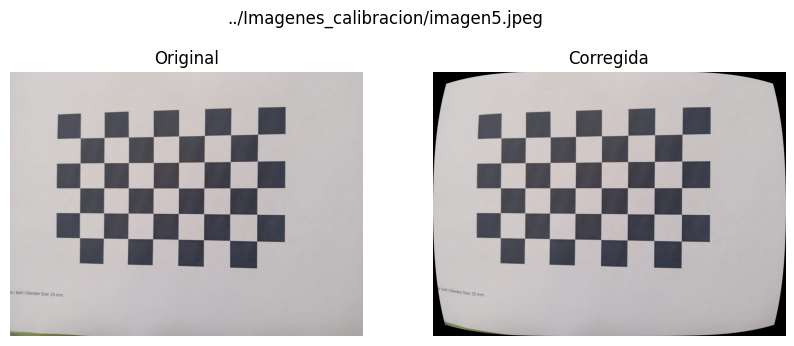

Guardada imagen corregida: ../Imagenes_corregidas/undistorted_imagen6.jpeg


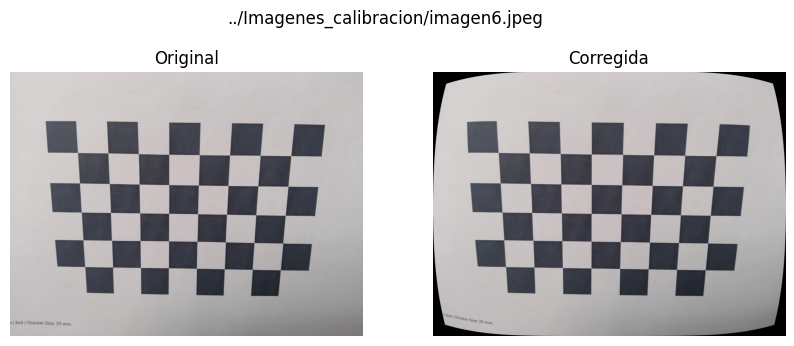

Guardada imagen corregida: ../Imagenes_corregidas/undistorted_imagen7.jpeg


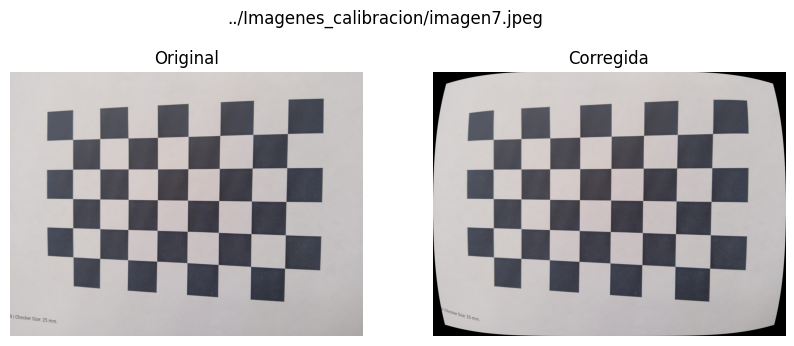

In [8]:
# Definir una nueva ruta de salida específica para las imágenes corregidas
OUTPUT_PATH_UNDISTORTED = '../Imagenes_corregidas/' 

# Crear el directorio de salida si no existe
if not os.path.exists(OUTPUT_PATH_UNDISTORTED):
    os.makedirs(OUTPUT_PATH_UNDISTORTED)
    print(f"Directorio creado para imágenes corregidas: {OUTPUT_PATH_UNDISTORTED}")

# --- MOSTRAR ORIGINAL VS CORREGIDA Y GUARDAR ---

# Mostrar original vs corregida
for filename in images:
    # Obtener el nombre base del archivo
    base_filename = os.path.basename(filename) 
    
    img = cv2.imread(filename)

    if img is None:
        print(f"No se pudo cargar: {filename}")
        continue

    h, w = img.shape[:2]

    # Obtener nueva matriz de cámara sin distorsión
    # alpha=1 intenta mantener la mayor cantidad posible de píxeles originales,
    # incluyendo los bordes negros y pixeles inválidos
    # alpha = 0 recorta la imagen para que solo queden los píxeles donde la rectificación fue totalmente exitosa
    new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(matrix, distortion, (w, h), 0, (w, h))

    # Corregir la distorsión
    undistorted = cv2.undistort(img, matrix, distortion, None, new_camera_mtx)

   # CAMBIO CLAVE: GUARDAR LA IMAGEN CORREGIDA
 
    output_filepath_undistorted = os.path.join(
        OUTPUT_PATH_UNDISTORTED, 
        f"undistorted_{base_filename}"
    )
    cv2.imwrite(output_filepath_undistorted, undistorted)
    print(f"Guardada imagen corregida: {output_filepath_undistorted}")
    # -------------------------------------------------------------------

    # Convertir a RGB para mostrar en matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

    # Mostrar lado a lado
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(undist_rgb)
    plt.title("Corregida")
    plt.axis("off")

    plt.suptitle(filename)
    plt.show()

Longitud focal fx: 1344.23
Longitud focal fy: 1350.77
¿fx ≈ fy? Sí

Centro de imagen: (800.0, 600.0)
Punto principal (cx, cy): (801.9, 613.1)
¿Está cerca del centro? Sí


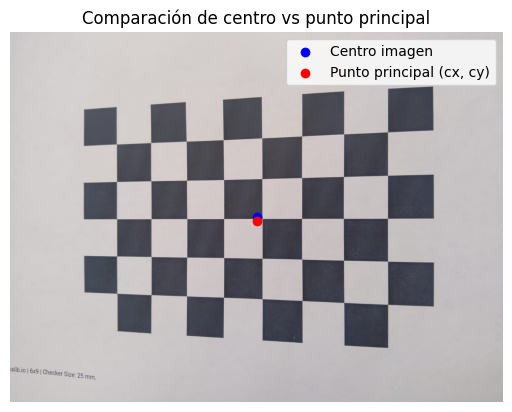

In [8]:
#Cargar una imagen de calibración
img = cv2.imread('../Imagenes_calibracion/imagen1.jpeg')  # ajusta la ruta si es necesario

if img is None:
    print("No se pudo cargar la imagen.")
else:
    h, w = img.shape[:2]

    #Extraer parámetros
    fx = matrix[0, 0]
    fy = matrix[1, 1]
    cx = matrix[0, 2]
    cy = matrix[1, 2]

    #Comparar focales
    print(f"Longitud focal fx: {fx:.2f}")
    print(f"Longitud focal fy: {fy:.2f}")
    print("¿fx ≈ fy?", "Sí" if abs(fx - fy) < 10 else "No")

    #Comparar punto principal con centro de imagen
    center_x = w / 2
    center_y = h / 2
    print(f"\nCentro de imagen: ({center_x:.1f}, {center_y:.1f})")
    print(f"Punto principal (cx, cy): ({cx:.1f}, {cy:.1f})")
    print("¿Está cerca del centro?", "Sí" if abs(cx - center_x) < 20 and abs(cy - center_y) < 20 else "No")

    #Mostrar imagen con marcas
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.scatter([center_x], [center_y], color='blue', label='Centro imagen')
    plt.scatter([cx], [cy], color='red', label='Punto principal (cx, cy)')
    plt.legend()
    plt.title("Comparación de centro vs punto principal")
    plt.axis("off")
    plt.show()

## 2. Implementar y comparar diferentes transformaciones de intensidad a nivel de píxel.
Con un teléfono celular tomen dos fotografías de la fachada (puede ser de la casa de algún integrante del equipo) a las 6 am y a las 7 pm. Las fotografías deben ser desde el mismo punto. Sobre las fotografías ilustren las siguientes operaciones (implementadas a mano):
* Ajuste de brillo
* Ajuste de contraste
* Corrección gama
* Sumen (A+B), resten(A-B), multipliquen (A*B) y dividan (A/B) ambas fotografías.

In [10]:
# Cargar las imágenes de la fachada tomadas de día y de noche
fachadaDia = cv2.imread(base_path + "fachada_dia.jpeg")  # Imagen tomada de día
fachadaNoche = cv2.imread(base_path + "fachada_noche.jpeg")  # Imagen tomada de noche

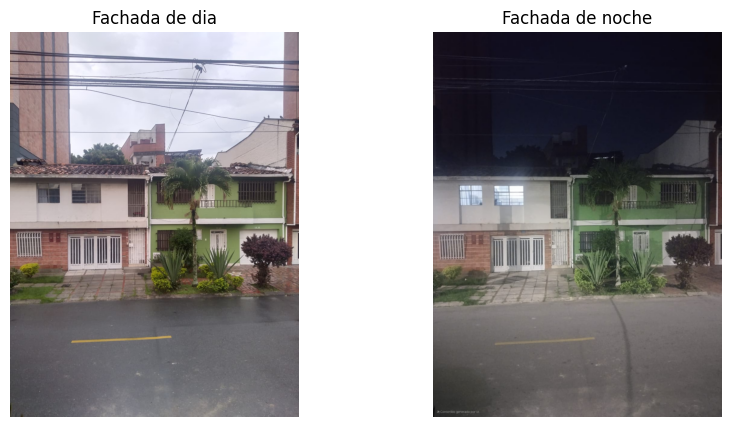

In [11]:
# Función para mostrar dos imágenes en color lado a lado con sus respectivos títulos
def mostrar_imagenes_color(imagen1, imagen2, titulo1, titulo2):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(imagen1, cv2.COLOR_BGR2RGB))  # Conversión de BGR a RGB para visualización correcta
    plt.title(titulo1)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(imagen2, cv2.COLOR_BGR2RGB))
    plt.title(titulo2)
    plt.axis("off")
    plt.show()

# Función para mostrar dos imágenes en escala de grises lado a lado con sus títulos
def mostrar_imagenes_grises(imagen1, imagen2, titulo1, titulo2):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(imagen1, cmap='gray')
    plt.title(titulo1)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(imagen2, cmap='gray')
    plt.title(titulo2)
    plt.axis("off")
    plt.show()

# Visualización de las imágenes originales en color
mostrar_imagenes_color(fachadaDia, fachadaNoche, "Fachada de dia", "Fachada de noche")

### Escala de grises
Conviertan ambas imágenes a escala de grises utilizando la fórmula de luminosidad: Y = 0.21 R + 0.72 G + 0.07 B

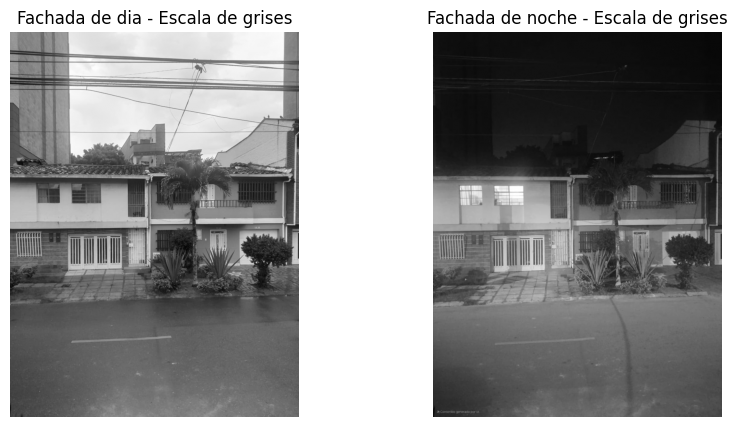

In [12]:
# Transformación a escala de grises usando la fórmula de luminosidad: Y = 0.21 R + 0.72 G + 0.07 B
# Se aplica la fórmula a cada imagen para obtener la versión en grises
fachada_dia_grises = np.dot(fachadaDia[...,:3], [0.21, 0.72, 0.07])  # Imagen de día en grises
fachada_noche_grises = np.dot(fachadaNoche[...,:3], [0.21, 0.72, 0.07])  # Imagen de noche en grises
# Mostrar las imágenes resultantes en escala de grises
mostrar_imagenes_grises(fachada_dia_grises, fachada_noche_grises, "Fachada de dia - Escala de grises", "Fachada de noche - Escala de grises")

In [13]:
# Función para saturar los valores de una imagen:
# Si el valor del píxel es mayor a 255 se asigna 255, si es menor a 0 se asigna 0.
def saturar_imagen(imagen):
    imagen_saturada = np.where(imagen > 255, 255, imagen)
    imagen_saturada = np.where(imagen_saturada < 0, 0, imagen_saturada)
    return imagen_saturada.astype('uint8')

#### Ajuste de brillo

In [14]:
# Función para ajustar el brillo de una imagen en escala de grises
def ajustar_brillo_imagen(imagen, valor_brillo):
    # Convertir la imagen a tipo int16 para evitar overflow/underflow
    imagen_int = imagen.astype('int16')
    
    # Ajustar el brillo sumando el valor especificado a cada píxel
    imagen_ajustada = imagen_int + valor_brillo
    
    # Asegurar que los valores estén en el rango [0, 255]
    imagen_ajustada = saturar_imagen(imagen_ajustada)
    
    # Convertir de nuevo a uint8 (saturar_imagen ya devuelve uint8)
    return imagen_ajustada

Imagenes originales en escala de grises


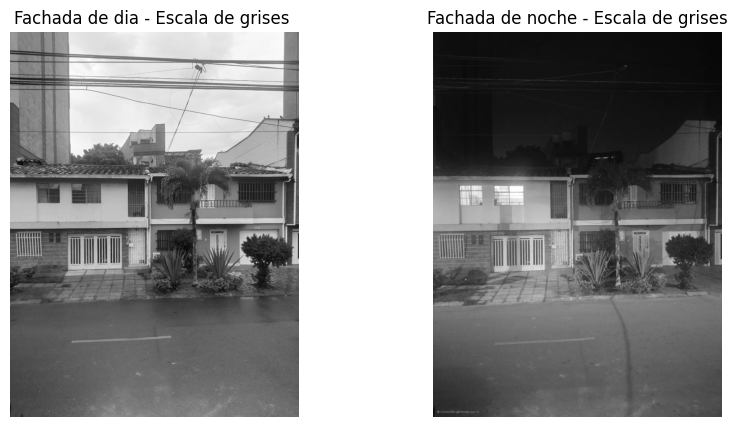

Imagenes con con brillo ajustado


In [ ]:
# Aplicación del ajuste de brillo a las imágenes en escala de grises
# Se disminuye el brillo de la imagen de día y se aumenta el de la imagen de noche
fachada_dia_grises_brillo_ajustado = ajustar_brillo_imagen(fachada_dia_grises, -70)  # Día: brillo reducido
fachada_noche_grises_brillo_ajustado = ajustar_brillo_imagen(fachada_noche_grises, 60)  # Noche: brillo aumentado
# Mostrar imágenes originales y con brillo ajustado
print("Imagenes originales en escala de grises")
mostrar_imagenes_grises(fachada_dia_grises, fachada_noche_grises, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")
print("Imagenes con con brillo ajustado")
mostrar_imagenes_grises(fachada_dia_grises_brillo_ajustado, fachada_noche_grises_brillo_ajustado, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")

# Cálculo y visualización de las medias de las imágenes antes y después del ajuste de brillo
print("medias de las imagenes originales")
print("Media fachada dia original:", np.mean(fachada_dia_grises))
print("Media fachada noche original:", np.mean(fachada_noche_grises))

print("medias de las imagenes con brillo ajustado")
print("Media fachada dia brillo ajustado:", np.mean(fachada_dia_grises_brillo_ajustado))
print("Media fachada noche brillo ajustado:", np.mean(fachada_noche_grises_brillo_ajustado))

#### Ajuste de contraste

In [16]:
# Función para ajustar el contraste de una imagen en escala de grises
def ajustar_contraste_imagen(imagen, factor_contraste):
    # Convertir la imagen a tipo float para evitar overflow/underflow
    imagen_float = imagen.astype('float32')
    
    # Ajustar el contraste: se centra en 128 y se multiplica por el factor
    imagen_ajustada = (imagen_float - 128) * factor_contraste + 128
    
    # Asegurar que los valores estén en el rango [0, 255]
    imagen_ajustada = saturar_imagen(imagen_ajustada)
    
    # Convertir de nuevo a uint8 (saturar_imagen ya devuelve uint8)
    return imagen_ajustada

Imagenes originales en escala de grises


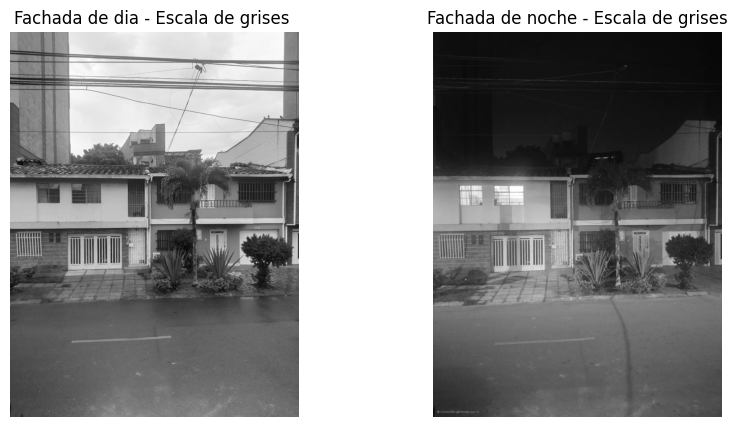

Imagenes con con contraste ajustado


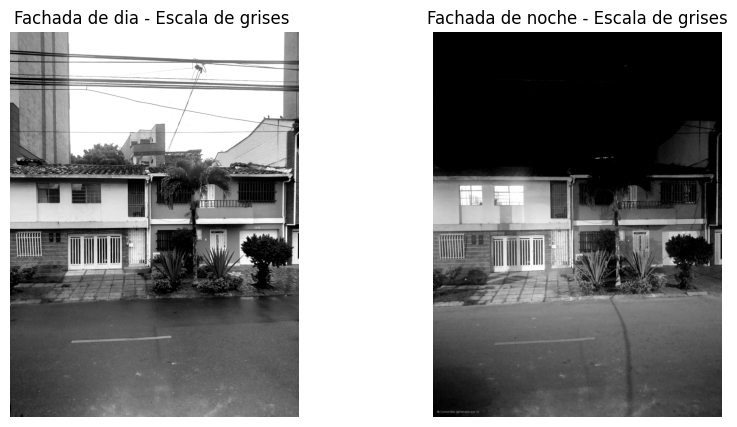

In [17]:
# Aplicación del ajuste de contraste a las imágenes en escala de grises
fachada_dia_grises_contraste_ajustado = ajustar_contraste_imagen(fachada_dia_grises, 1.5)  # Día: contraste aumentado
fachada_noche_grises_contraste_ajustado = ajustar_contraste_imagen(fachada_noche_grises, 1.5)  # Noche: contraste aumentado
# Mostrar imágenes originales y con contraste ajustado
print("Imagenes originales en escala de grises")
mostrar_imagenes_grises(fachada_dia_grises, fachada_noche_grises, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")
print("Imagenes con con contraste ajustado")
mostrar_imagenes_grises(fachada_dia_grises_contraste_ajustado, fachada_noche_grises_contraste_ajustado, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")

#### Corrección gama

In [18]:
# Función para aplicar corrección gamma a una imagen en escala de grises
def corregir_gama_imagen(imagen, gamma):
    # Convertir la imagen a tipo float y normalizar a [0, 1]
    imagen_float = imagen.astype('float32') 
    
    # Aplicar corrección gamma: potencia sobre la imagen normalizada
    imagen_ajustada = 255 * np.power((imagen_float/255), gamma)
    
    # Asegurar que los valores estén en el rango [0, 255]
    # Este paso se puede omitir dado que en el cálculo no se salen de rango, pero se mantiene por seguridad
    imagen_ajustada = saturar_imagen(imagen_ajustada)
    
    # Convertir de nuevo a uint8 (saturar_imagen ya devuelve uint8)
    return imagen_ajustada

Imagenes originales en escala de grises


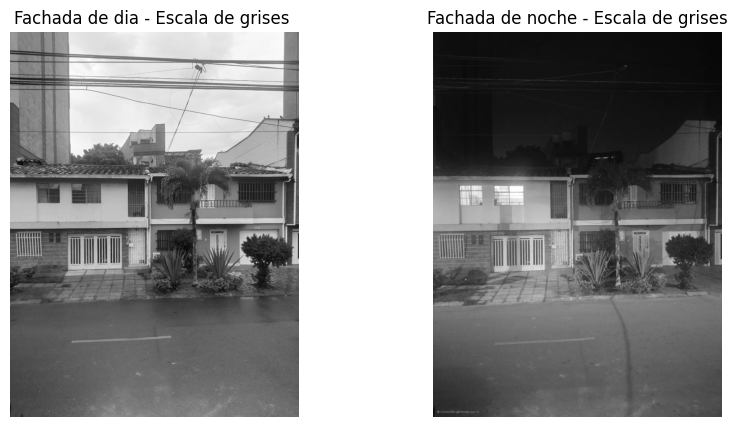

Imagenes con correccion gama (gamma <1 - aclara)


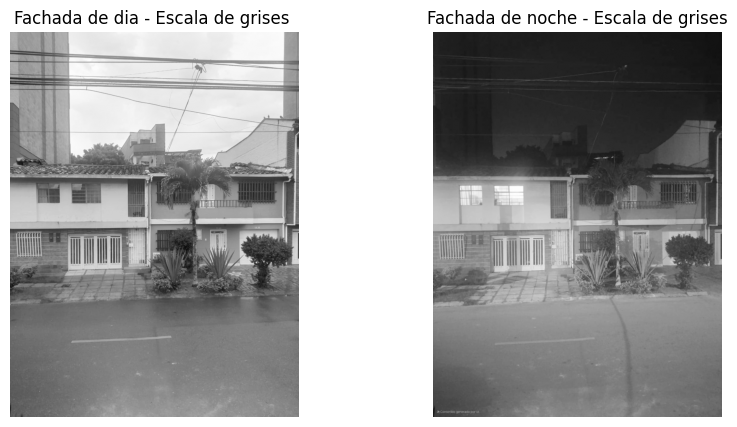

Imagenes con correccion gama (gamma >1 - oscurece)


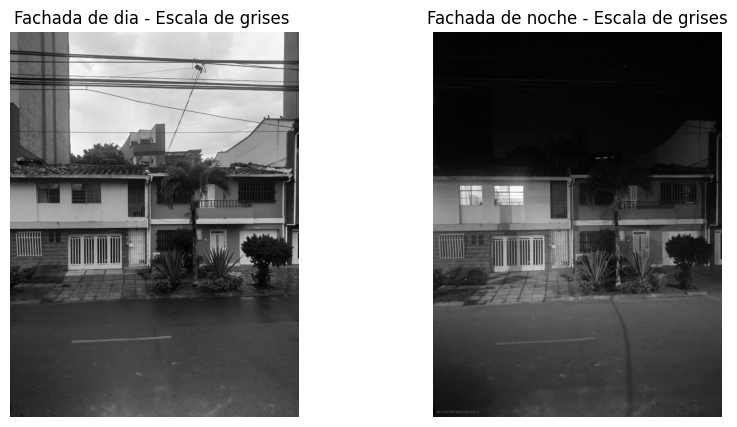

In [19]:
# Aplicación de la corrección gamma a las imágenes en escala de grises
# Gamma < 1 aclara la imagen, gamma > 1 oscurece la imagen
fachada_dia_grises_gama_ajustada_aclara = corregir_gama_imagen(fachada_dia_grises, 0.7)  # Día: gamma aclara
fachada_noche_grises_gama_ajustada_aclara = corregir_gama_imagen(fachada_noche_grises, 0.7)  # Noche: gamma aclara
fachada_dia_grises_gama_ajustada_oscurece = corregir_gama_imagen(fachada_dia_grises, 1.5)  # Día: gamma oscurece
fachada_noche_grises_gama_ajustada_oscurece = corregir_gama_imagen(fachada_noche_grises, 1.5)  # Noche: gamma oscurece
# Mostrar imágenes originales y con corrección gamma aplicada
print("Imagenes originales en escala de grises")
mostrar_imagenes_grises(fachada_dia_grises, fachada_noche_grises, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")
print("Imagenes con correccion gama (gamma <1 - aclara)")
mostrar_imagenes_grises(fachada_dia_grises_gama_ajustada_aclara, fachada_noche_grises_gama_ajustada_aclara, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")
print("Imagenes con correccion gama (gamma >1 - oscurece)")
mostrar_imagenes_grises(fachada_dia_grises_gama_ajustada_oscurece, fachada_noche_grises_gama_ajustada_oscurece, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")

#### Operaciones aritméticas entre imágenes

In [20]:
# Funciones para realizar operaciones aritméticas entre imágenes en escala de grises
def suma_imagenes(imagen1, imagen2):
    # Convertir las imágenes a tipo int16 para evitar overflow
    imagen1_int = imagen1.astype('int16')
    imagen2_int = imagen2.astype('int16')
    
    # Sumar las imágenes píxel a píxel
    imagen_suma = imagen1_int + imagen2_int
    
    # Asegurar que los valores estén en el rango [0, 255]
    imagen_suma = saturar_imagen(imagen_suma)
    
    return imagen_suma

def resta_imagenes(imagen1, imagen2):
    # Convertir las imágenes a tipo int16 para evitar underflow
    imagen1_int = imagen1.astype('int16')
    imagen2_int = imagen2.astype('int16')
    
    # Restar las imágenes píxel a píxel
    imagen_resta = imagen1_int - imagen2_int
    
    # Asegurar que los valores estén en el rango [0, 255]
    imagen_resta = saturar_imagen(imagen_resta)
    
    return imagen_resta

def multiplicacion_imagenes(imagen1, imagen2):
    # Convertir las imágenes a tipo float32 para evitar overflow
    imagen1_float = imagen1.astype('float32')
    imagen2_float = imagen2.astype('float32')
    
    # Multiplicar las imágenes normalizando a [0,1] y reescalando a [0,255]
    imagen_multiplicacion = (imagen1_float / 255) * (imagen2_float / 255) * 255
    
    # Asegurar que los valores estén en el rango [0, 255]
    imagen_multiplicacion = saturar_imagen(imagen_multiplicacion)
    
    return imagen_multiplicacion

def division_imagenes(imagen1, imagen2):
    # Convertir las imágenes a tipo float32 para evitar overflow
    imagen1_float = imagen1.astype('float32')
    imagen2_float = imagen2.astype('float32')
    
    # Evitar división por cero reemplazando ceros por unos
    imagen2_float[imagen2_float == 0] = 1
    
    # Dividir las imágenes y reescalar a [0,255]
    imagen_division = (imagen1_float / imagen2_float) * 255
    
    # Asegurar que los valores estén en el rango [0, 255]
    imagen_division = saturar_imagen(imagen_division)
    
    return imagen_division

imagenes originales  en grises


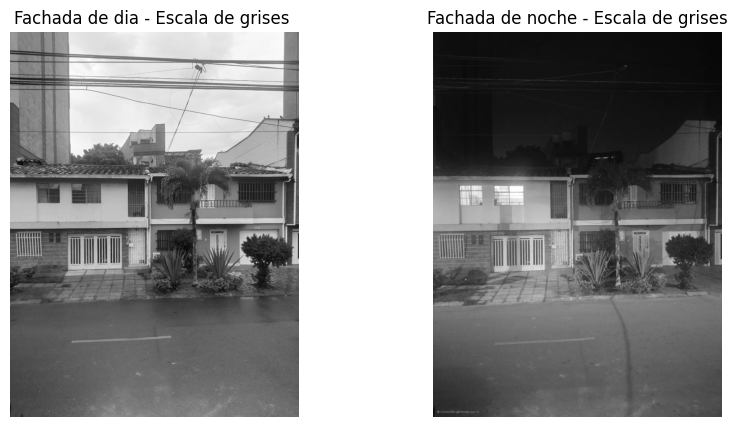

Resultado de las imagenes


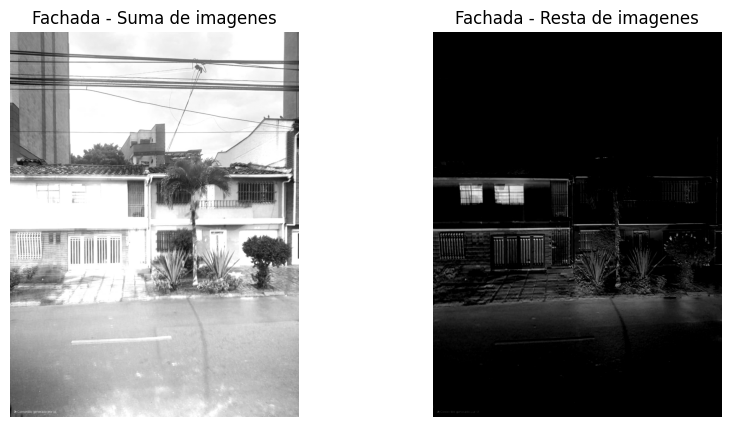

In [21]:
# Suma y resta de imágenes en escala de grises
fachada_grises_suma = suma_imagenes(fachada_dia_grises, fachada_noche_grises)  # Suma píxel a píxel
fachada_grises_resta = resta_imagenes(fachada_noche_grises, fachada_dia_grises)  # Resta píxel a píxel
# Mostrar resultados de suma y resta
print("imagenes originales  en grises")
mostrar_imagenes_grises(fachada_dia_grises, fachada_noche_grises, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")
print("Resultado de las imagenes")
mostrar_imagenes_grises(fachada_grises_suma, fachada_grises_resta, "Fachada - Suma de imagenes", "Fachada - Resta de imagenes")

imagenes originales  en grises


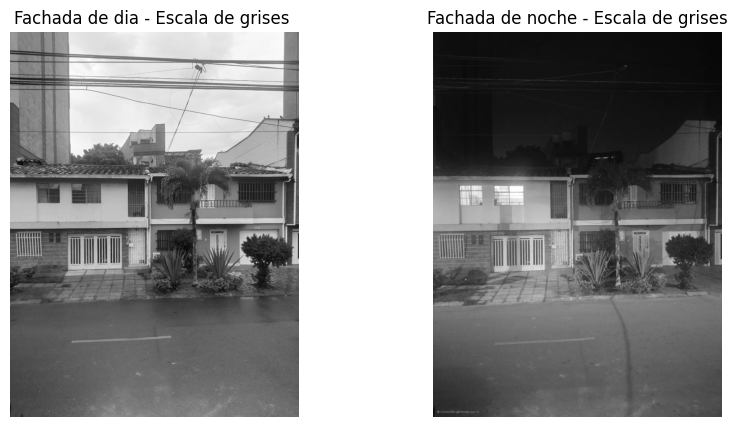

Resultado de las imagenes


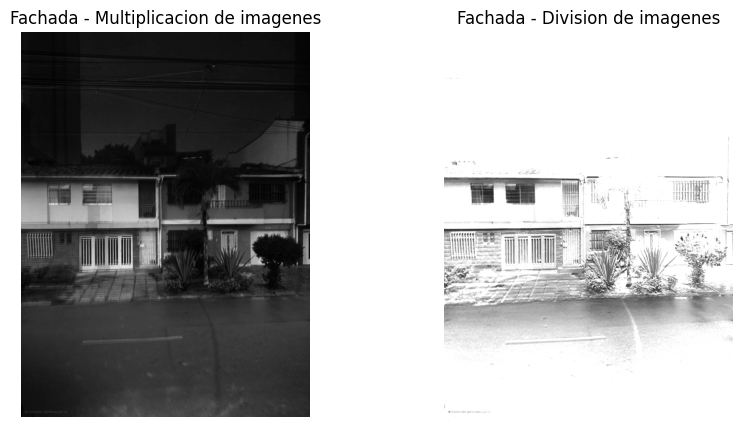

In [22]:
# Multiplicación y división de imágenes en escala de grises
fachada_grises_multiplicacion = multiplicacion_imagenes(fachada_dia_grises, fachada_noche_grises)  # Multiplicación píxel a píxel
fachada_grises_division = division_imagenes(fachada_dia_grises, fachada_noche_grises)  # División píxel a píxel
# Mostrar resultados de multiplicación y división
print("imagenes originales  en grises")
mostrar_imagenes_grises(fachada_dia_grises, fachada_noche_grises, "Fachada de dia - Escala de grises ", "Fachada de noche - Escala de grises")
print("Resultado de las imagenes")
mostrar_imagenes_grises(fachada_grises_multiplicacion, fachada_grises_division, "Fachada - Multiplicacion de imagenes", "Fachada - Division de imagenes")

### RGB

Imagenes originales en RGB


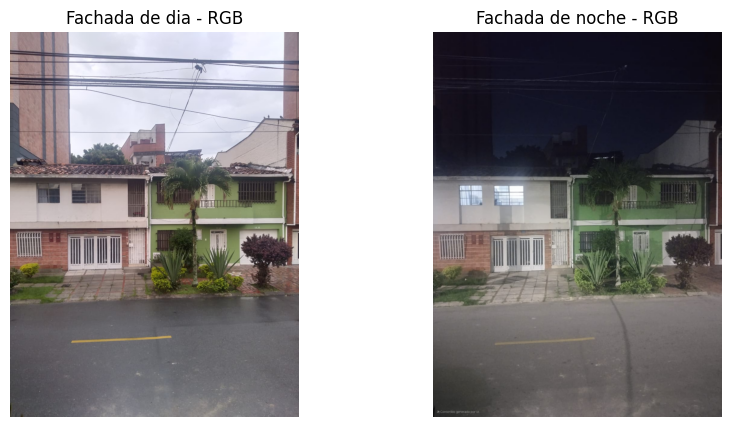

In [23]:
# Visualización de las imágenes originales en RGB
print("Imagenes originales en RGB")
mostrar_imagenes_color(fachadaDia, fachadaNoche, "Fachada de dia - RGB", "Fachada de noche - RGB")

#### ajuste de brillo en RGB

In [24]:
# Función para ajustar el brillo de una imagen RGB de manera independiente para cada canal
def ajuste_brillo_imagen_rgb(imagen, r, g, b):
    # Separar los canales RGB usando numpy (cada canal es una matriz 2D)
    canales = [imagen[..., i].copy() for i in range(3)]
    
    # Ajustar el brillo de cada canal (se respeta el mapeo original)
    canales[0] = ajustar_brillo_imagen(canales[0], r)  # Canal R
    canales[1] = ajustar_brillo_imagen(canales[1], g)  # Canal G
    canales[2] = ajustar_brillo_imagen(canales[2], b)  # Canal B
    
    # Combinar los canales ajustados de nuevo en una imagen RGB usando numpy
    imagen_ajustada = np.stack(canales, axis=2)
    
    return imagen_ajustada

Imagenes originales en RGB


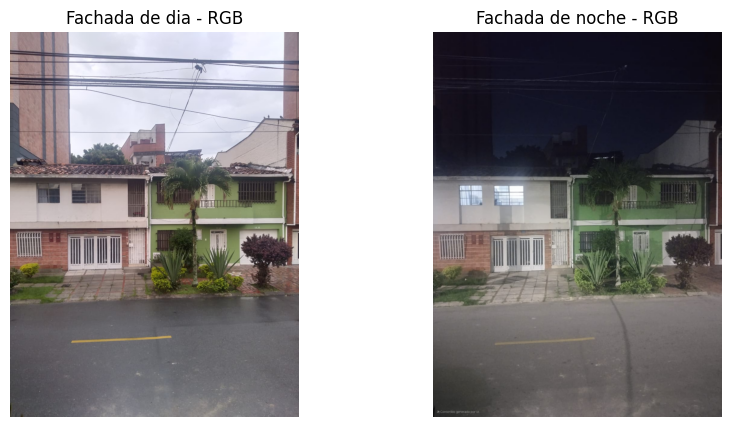

Imagenes con con brillo ajustado en RGB


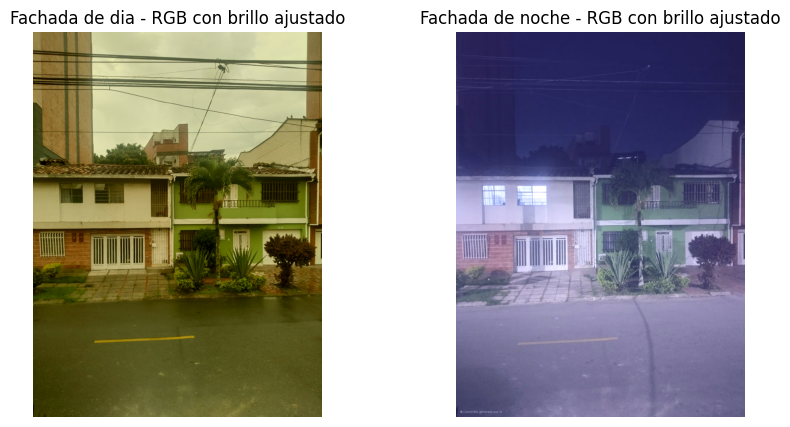

In [25]:
# Aplicación del ajuste de brillo a las imágenes en RGB
fachada_dia_rgb_brillo_ajustado = ajuste_brillo_imagen_rgb(fachadaDia, -80, -20, -20)  # Día: brillo reducido en cada canal
fachada_noche_rgb_brillo_ajustado = ajuste_brillo_imagen_rgb(fachadaNoche, 60, 20, 20)  # Noche: brillo aumentado en cada canal
print("Imagenes originales en RGB")
mostrar_imagenes_color(fachadaDia, fachadaNoche, "Fachada de dia - RGB", "Fachada de noche - RGB")
print("Imagenes con con brillo ajustado en RGB")
mostrar_imagenes_color(fachada_dia_rgb_brillo_ajustado, fachada_noche_rgb_brillo_ajustado, "Fachada de dia - RGB con brillo ajustado", "Fachada de noche - RGB con brillo ajustado")

## 3. Implementar y aplicar transformaciones de rotación y traslación.
Creen una función que:
- Cargue una imagen
- Aplique 5-8 transformaciones sucesivas (traslaciones, rotaciones, escalas)
- Genere un GIF animado o video mostrando la secuencia
- Guarden cada frame intermedio

In [34]:


def transformar_imagen(ruta_imagen, salida_gif="animacion.gif"):
    carpeta_frames = "frames_temp"

    #  Si ya existen los resultados, no ejecutar la función
    if os.path.exists(carpeta_frames) and os.path.exists(salida_gif):
        print("Las carpetas y el GIF ya existen. No se ejecutará la función.")
        return

    # Crear carpeta temporal para los frames (solo si no existe)
    os.makedirs(carpeta_frames, exist_ok=True)

    # Cargar imagen original
    img_original = Image.open(ruta_imagen).convert("RGBA")
    ancho, alto = img_original.size

    # Lista para guardar los frames
    frames = []

    # Definir transformaciones (rotación, traslación, escala)
    transformaciones = [
        {"rot": 0,   "tx": 0,  "ty": 0,  "scale": 1.0},
        {"rot": 15,  "tx": 20, "ty": 0,  "scale": 1.1},
        {"rot": 30,  "tx": 40, "ty": 10, "scale": 1.2},
        {"rot": 60,  "tx": 60, "ty": 20, "scale": 1.1},
        {"rot": 90,  "tx": 80, "ty": 40, "scale": 0.9},
        {"rot": 120, "tx": 60, "ty": 60, "scale": 0.8},
        {"rot": 150, "tx": 40, "ty": 80, "scale": 0.9},
        {"rot": 180, "tx": 0,  "ty": 100,"scale": 1.0},
    ]

    for i, t in enumerate(transformaciones):
        # Aplicar escala
        nuevo_ancho = int(ancho * t["scale"])
        nuevo_alto = int(alto * t["scale"])
        img_transformada = img_original.resize((nuevo_ancho, nuevo_alto))

        # Aplicar rotación
        img_transformada = img_transformada.rotate(t["rot"], expand=True)

        # Crear fondo blanco
        fondo = Image.new("RGBA", (ancho * 2, alto * 2), (255, 255, 255, 255))

        # Calcular posición
        x = ancho // 2 + t["tx"]
        y = alto // 2 + t["ty"]

        # Pegar imagen transformada
        fondo.paste(img_transformada, (x, y), img_transformada)

        # Guardar frame
        frame_path = os.path.join(carpeta_frames, f"frame_{i:02d}.png")
        fondo.save(frame_path)
        frames.append(imageio.v3.imread(frame_path))

    # Crear GIF con loop infinito
    imageio.mimsave(salida_gif, frames, duration=0.5, loop=0)

    print(f" GIF generado correctamente: {salida_gif}")
    print(f" Frames guardados en: {os.path.abspath(carpeta_frames)}")

# Ejemplo de uso
transformar_imagen("../images/Imagen_gif.jpeg", "transformaciones.gif")

 GIF generado correctamente: transformaciones.gif
 Frames guardados en: /app/Taller 1/Notebooks/frames_temp


## 4. Entender y manipular la distribución de intensidades de una imagen.
Lleve a cabo la ecualización del histograma (usando la función de distribución acumulada) de las imágenes de la fachada del punto anterior. 
* ¿Qué diferencias hay entre los histogramas de la imagen tomada de día y la imagen tomada de noche? 
* ¿Cuáles son las transformaciones de ecualización en cada caso?

### Escala de grises

In [27]:
# Función para ecualizar el histograma de una imagen en escala de grises usando la función de distribución acumulada (CDF)
def equalizar_imagen_grises(imagen):
    """Equaliza el histograma de una imagen en escala de grises usando la CDF."""
    # Convertir la imagen a enteros en [0,255] en caso de que sea float (p.ej. resultado de np.dot)
    imagen_uint8 = np.clip(np.rint(imagen), 0, 255).astype('uint8')

    # Calcular el histograma sobre valores enteros
    hist, bins = np.histogram(imagen_uint8.flatten(), 256, [0,256])

    # Calcular la función de distribución acumulada (CDF)
    cdf = hist.cumsum()

    # Evitar problemas si la imagen es constante (cdf.max()==cdf.min())
    cdf_m = np.ma.masked_equal(cdf, 0)
    if cdf_m.max() == cdf_m.min():
        return imagen_uint8.copy()

    # Realizar la equalización del histograma (normalizar la CDF)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())

    # Rellenar los valores enmascarados con cero y convertir a uint8
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')

    # Mapear los valores originales de la imagen (ya convertidos a uint8) a los nuevos valores equalizados
    imagen_equalizada = cdf_final[imagen.astype('uint8')]

    return imagen_equalizada

In [28]:
# Funciones para calcular y mostrar histogramas de imágenes en escala de grises, con y sin ecualización
def calcular_histogramas_grises(imagen1, imagen2):
    """Calcula los histogramas de dos imágenes, con y sin ecualización."""
    # Calcular histogramas sin ecualización
    hist1_sin_eq, bins1_sin_eq = np.histogram(imagen1.flatten(), bins=256, range=[0, 256])
    hist2_sin_eq, bins2_sin_eq = np.histogram(imagen2.flatten(), bins=256, range=[0, 256])

    # Calcular histogramas con ecualización
    imagen1_eq = equalizar_imagen_grises(imagen1)
    imagen2_eq = equalizar_imagen_grises(imagen2)
    hist1_con_eq, bins1_con_eq = np.histogram(imagen1_eq.flatten(), bins=256, range=[0, 256])
    hist2_con_eq, bins2_con_eq = np.histogram(imagen2_eq.flatten(), bins=256, range=[0, 256])

    datos_hist1 = (hist1_sin_eq, bins1_sin_eq, hist1_con_eq, bins1_con_eq)
    datos_hist2 = (hist2_sin_eq, bins2_sin_eq, hist2_con_eq, bins2_con_eq)
    
    return datos_hist1, datos_hist2

def mostrar_histogramas_grises(datos_hist1, datos_hist2, titulo1, titulo2):
    """Muestra cuatro histogramas: dos por imagen (original y ecualizado)."""
    hist1_sin_eq, bins1_sin_eq, hist1_con_eq, bins1_con_eq = datos_hist1
    hist2_sin_eq, bins2_sin_eq, hist2_con_eq, bins2_con_eq = datos_hist2

    plt.figure(figsize=(10, 10))

    # Histograma de la primera imagen (sin ecualización)
    plt.subplot(2, 2, 1)
    plt.plot(bins1_sin_eq[:-1], hist1_sin_eq, color='blue')
    plt.title(f'Histograma de {titulo1} (sin ecualización)')
    plt.xlabel('Intensidad de píxel')
    plt.ylabel('Frecuencia')
    plt.xlim([0, 255])
    plt.grid()

    # Histograma de la primera imagen (con ecualización)
    plt.subplot(2, 2, 2)
    plt.plot(bins1_con_eq[:-1], hist1_con_eq, color='green')
    plt.title(f'Histograma de {titulo1} (con equalización)')
    plt.xlabel('Intensidad de píxel')
    plt.ylabel('Frecuencia')
    plt.xlim([0, 255])
    plt.grid()

    # Histograma de la segunda imagen (sin ecualización)
    plt.subplot(2, 2, 3)
    plt.plot(bins2_sin_eq[:-1], hist2_sin_eq, color='blue')
    plt.title(f'Histograma de {titulo2} (sin equalización)')
    plt.xlabel('Intensidad de píxel')
    plt.ylabel('Frecuencia')
    plt.xlim([0, 255])
    plt.grid()

    # Histograma de la segunda imagen (con ecualización)
    plt.subplot(2, 2, 4)
    plt.plot(bins2_con_eq[:-1], hist2_con_eq, color='green')
    plt.title(f'Histograma de {titulo2} (con equalización)')
    plt.xlabel('Intensidad de píxel')
    plt.ylabel('Frecuencia')
    plt.xlim([0, 255])
    plt.grid()

    plt.tight_layout()
    plt.show()

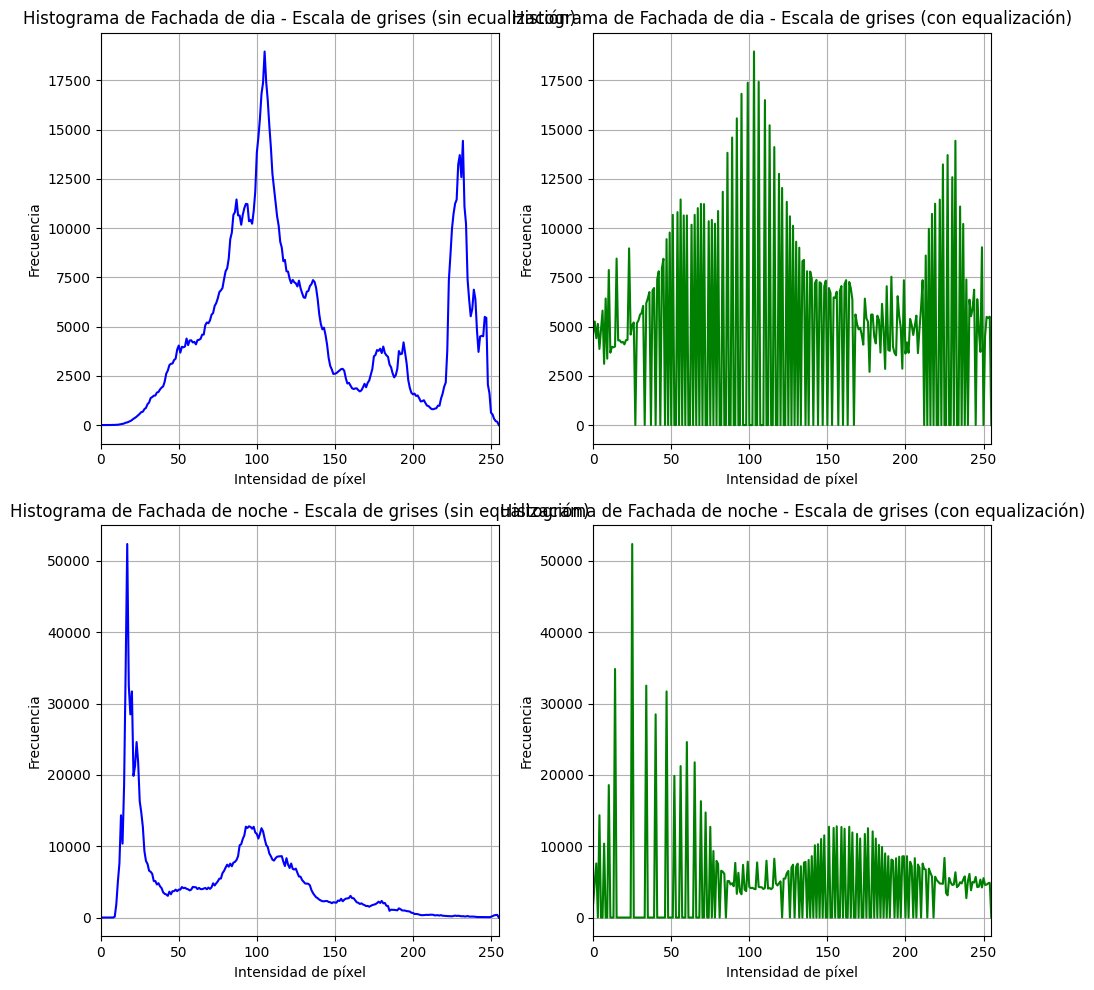

In [29]:
# Cálculo y visualización de los histogramas de las imágenes en escala de grises
# 1. Calcular los histogramas (original y ecualizado) para ambas imágenes
datos_hist_dia, datos_hist_noche = calcular_histogramas_grises(fachada_dia_grises, fachada_noche_grises)

# 2. Mostrar los histogramas obtenidos
mostrar_histogramas_grises(datos_hist_dia, datos_hist_noche, "Fachada de dia - Escala de grises", "Fachada de noche - Escala de grises")

#### analisis de resultados
texto


### RGB


In [30]:
# Función para ecualizar el histograma de una imagen en color usando el canal V de HSV
def equalizar_imagen_color_hsv(imagen_bgr):
    # Verificar que la imagen se haya cargado correctamente
    if imagen_bgr is None:
        # Si la imagen no se pudo cargar, devolvemos 'None'
        return None

    # 1. Convertir la imagen de BGR a HSV
    hsv = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2HSV)
    
    # 2. Separar los canales H, S, V
    h, s, v = cv2.split(hsv)
    
    # 3. Ecualizar SOLAMENTE el canal 'V' (Valor/Brillo)
    v_equalizado = cv2.equalizeHist(v)
    
    # 4. Volver a unir los canales
    hsv_equalizado = cv2.merge([h, s, v_equalizado])
    
    # 5. Convertir la imagen de vuelta de HSV a BGR
    imagen_final_bgr = cv2.cvtColor(hsv_equalizado, cv2.COLOR_HSV2BGR)
    
    return imagen_final_bgr

In [31]:
# Funciones para calcular y mostrar histogramas RGB de imágenes en color, con y sin ecualización
def calcular_histogramas_rgb(imagen_bgr1, imagen_bgr2):
    """Calcula los histogramas RGB de dos imágenes, con y sin ecualización."""
    # --- 1. Ecualizar ambas imágenes ---
    img1_eq = equalizar_imagen_color_hsv(imagen_bgr1)
    img2_eq = equalizar_imagen_color_hsv(imagen_bgr2)

    # --- 2. Función interna para calcular los 3 histogramas de una imagen ---
    def _calc_hist_rgb(imagen):
        if imagen is None:
            # Si la imagen no existe, devuelve None para cada histograma
            return None, None, None
        # Separa los canales y calcula el histograma para cada uno
        b, g, r = cv2.split(imagen)
        hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
        hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])
        return hist_b, hist_g, hist_r

    # --- 3. Calcular todos los histogramas ---
    # Para la imagen 1 (original y ecualizada)
    hists_bgr1_orig = _calc_hist_rgb(imagen_bgr1)
    hists_bgr1_eq = _calc_hist_rgb(img1_eq)
    
    # Para la imagen 2 (original y ecualizada)
    hists_bgr2_orig = _calc_hist_rgb(imagen_bgr2)
    hists_bgr2_eq = _calc_hist_rgb(img2_eq)

    # --- 4. Agrupar los datos para devolverlos ---
    # datos_hist1 = (hist_b_orig, hist_g_orig, hist_r_orig, hist_b_eq, hist_g_eq, hist_r_eq)
    datos_hist1 = hists_bgr1_orig + hists_bgr1_eq
    datos_hist2 = hists_bgr2_orig + hists_bgr2_eq
    
    return datos_hist1, datos_hist2

def mostrar_histogramas_rgb(datos_hist1, datos_hist2, titulo1, titulo2):
    """Muestra cuatro histogramas RGB a partir de los datos precalculados."""
    
    # --- 1. Desempaquetar los datos ---
    # Seis histogramas por cada imagen original
    hist_b1_orig, hist_g1_orig, hist_r1_orig, hist_b1_eq, hist_g1_eq, hist_r1_eq = datos_hist1
    hist_b2_orig, hist_g2_orig, hist_r2_orig, hist_b2_eq, hist_g2_eq, hist_r2_eq = datos_hist2

    # --- 2. Crear el grid 2x2 para los gráficos ---
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    fig.suptitle("Comparación de Histogramas RGB (Original vs. Ecualizado)", fontsize=16)

    # --- 3. Función interna para dibujar un histograma RGB en un 'eje' (ax) ---
    def _plot_rgb_hist_on_axis(ax, hists_bgr, titulo_grafico):
        hist_b, hist_g, hist_r = hists_bgr
        
        # Comprobar si los datos del histograma son válidos
        if hist_b is None or hist_g is None or hist_r is None:
            ax.set_title(f"{titulo_grafico}\n(Error: Datos no calculados)")
            return
        
        # Dibujar los 3 histogramas en el eje (ax)
        ax.plot(hist_b, color='blue', label='B')
        ax.plot(hist_g, color='green', label='G')
        ax.plot(hist_r, color='red', label='R')
        
        # Configurar el gráfico
        ax.set_title(titulo_grafico)
        ax.set_xlabel('Intensidad (0-255)')
        ax.set_ylabel('Frecuencia')
        ax.set_xlim([0, 256])
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)

    # --- 4. Dibujar los 4 gráficos en sus posiciones ---
    _plot_rgb_hist_on_axis(ax1, (hist_b1_orig, hist_g1_orig, hist_r1_orig), f'Histograma de {titulo1} (Original)')
    _plot_rgb_hist_on_axis(ax2, (hist_b1_eq, hist_g1_eq, hist_r1_eq), f'Histograma de {titulo1} (Ecualizada)')
    _plot_rgb_hist_on_axis(ax3, (hist_b2_orig, hist_g2_orig, hist_r2_orig), f'Histograma de {titulo2} (Original)')
    _plot_rgb_hist_on_axis(ax4, (hist_b2_eq, hist_g2_eq, hist_r2_eq), f'Histograma de {titulo2} (Ecualizada)')
    
    # --- 5. Mostrar el resultado ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

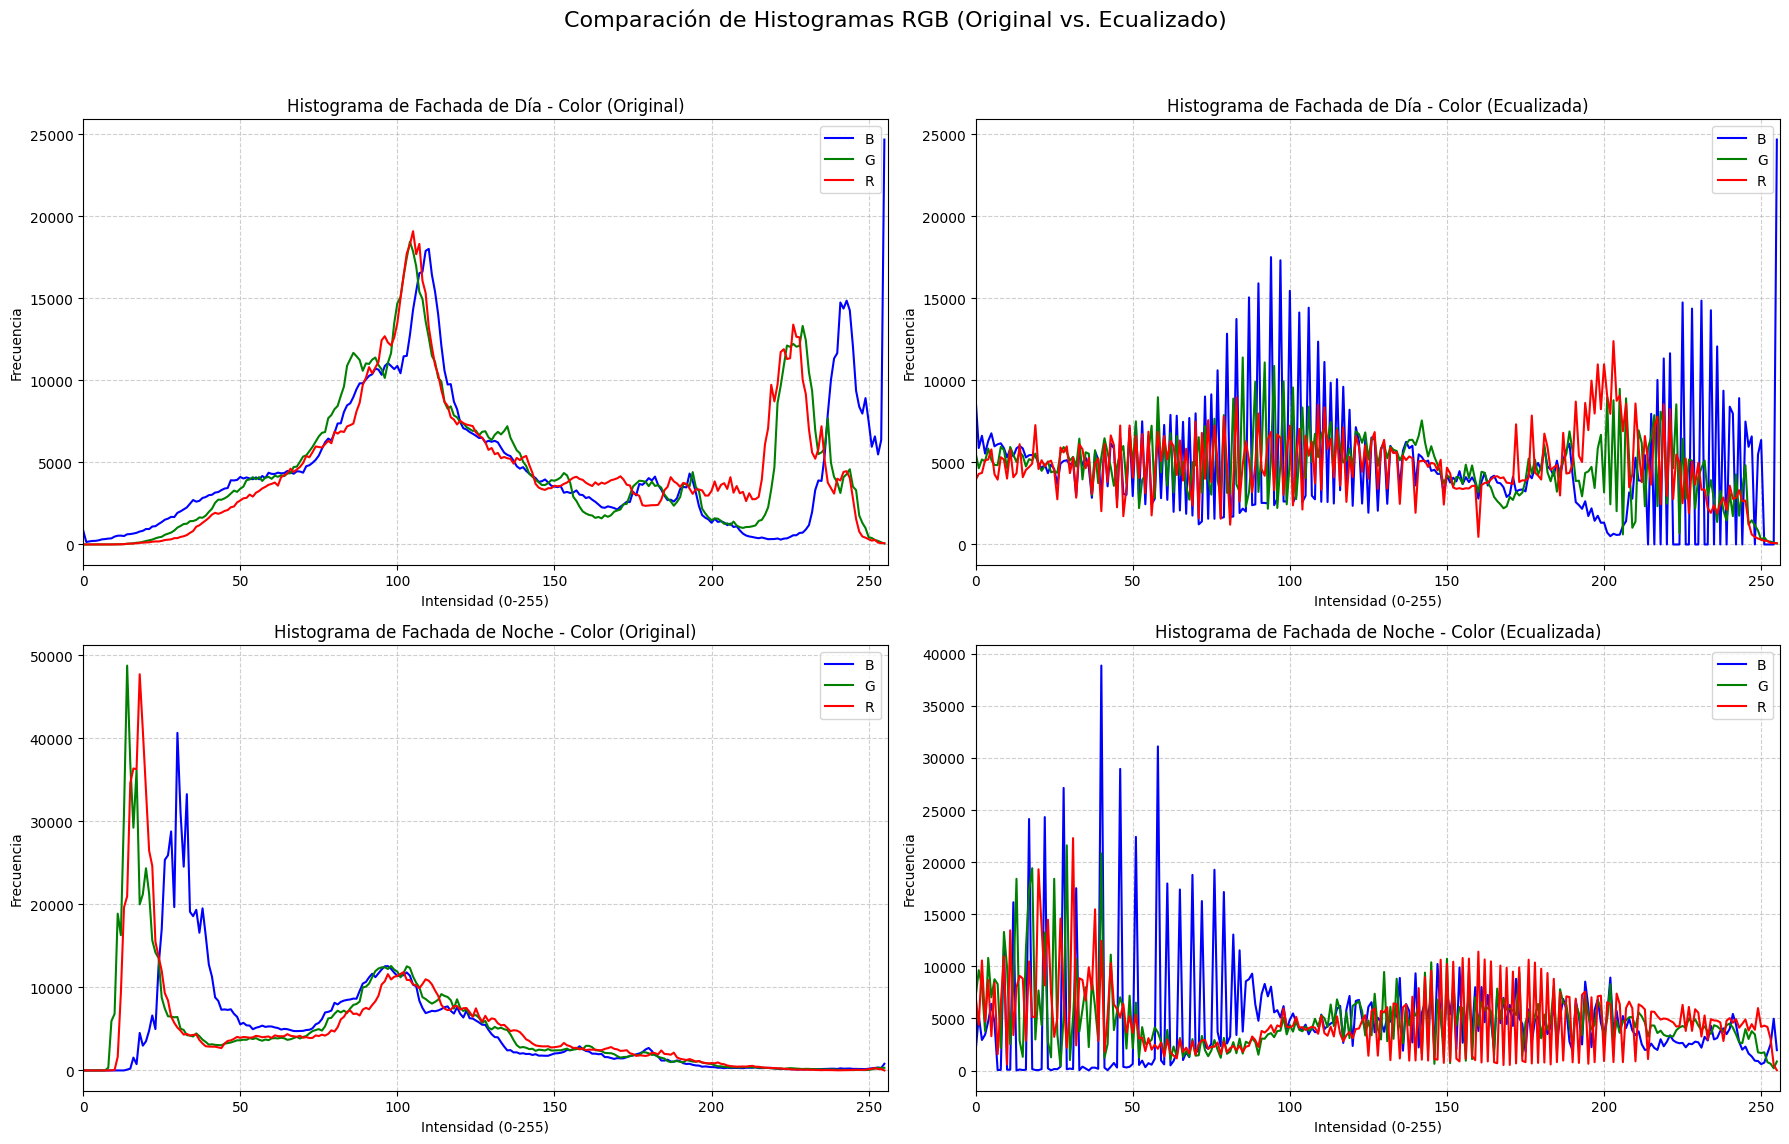

In [32]:
# Cálculo y visualización de los histogramas RGB para ambas imágenes (día y noche)
# 1. Calcular los histogramas RGB (original y ecualizado) para ambas imágenes
datos_hist_dia_rgb, datos_hist_noche_rgb = calcular_histogramas_rgb(fachadaDia, fachadaNoche)

# 2. Mostrar los histogramas calculados
mostrar_histogramas_rgb(datos_hist_dia_rgb, datos_hist_noche_rgb, "Fachada de Día - Color", "Fachada de Noche - Color")

#### Analisis
texto

## 5. Implementar técnicas fundamentales de segmentación de imágenes.
Capturen una escena con objetos de colores distintos de la Universidad Nacional o de la oficina de alguno de los integrantes del equipo. Debe ser con una cámara de un teléfono celular.
- Segmenten cada objeto por su color
- Cuenten cuántos objetos de cada color hay
- Calculen el área de cada objeto

--- Procesando el color: Rosa ---
Se encontraron 9 objetos.
--- Procesando el color: Blanco ---
Se encontraron 12 objetos.
--- Procesando el color: Amarillo ---
Se encontraron 8 objetos.
--- Procesando el color: Rosa Pálido ---
Se encontraron 7 objetos.
--- Procesando el color: Azul Pastel ---
Se encontraron 1 objetos.


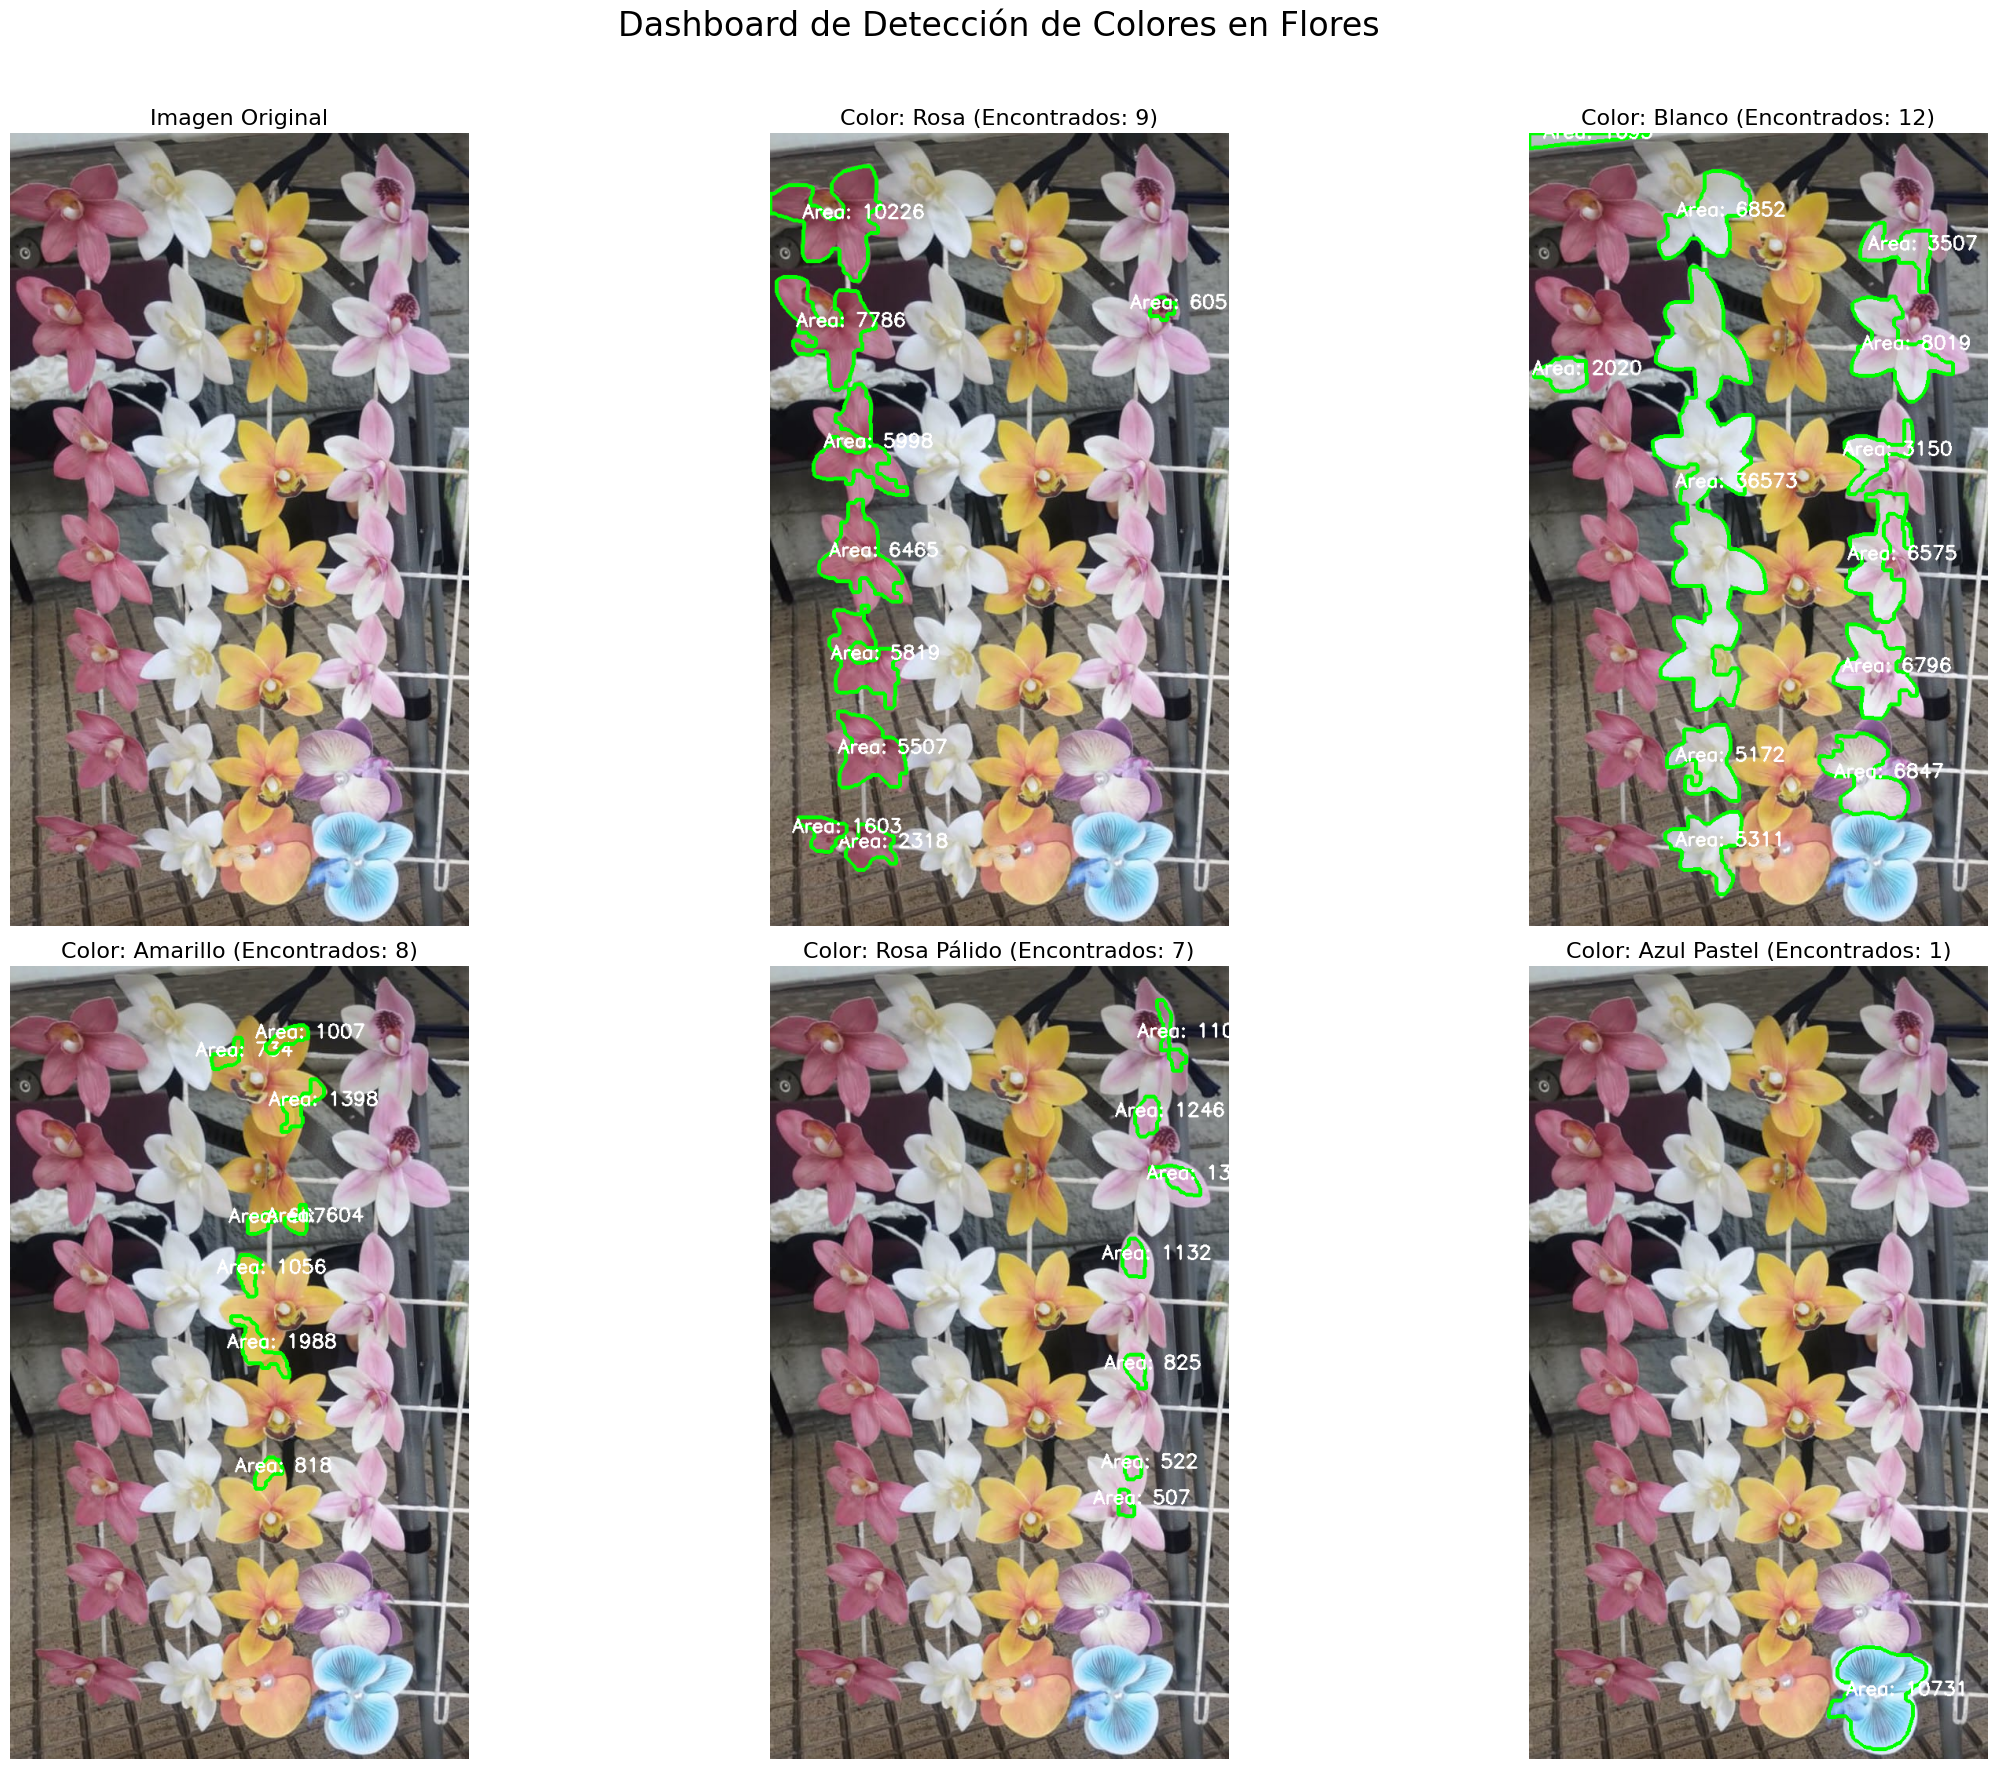



--- RESUMEN FINAL ---
Color: Rosa
  - Cantidad de objetos: 9
  - Área promedio de los objetos: 5147.44 pixeles
  - Áreas individuales: [2318, 1603, 5507, 5819, 6465, 5998, 605, 7786, 10226]
-----------------------
Color: Blanco
  - Cantidad de objetos: 12
  - Área promedio de los objetos: 7709.58 pixeles
  - Áreas individuales: [5311, 6847, 5172, 6796, 6575, 3150, 2020, 8019, 36573, 3507, 6852, 1693]
-----------------------
Color: Amarillo
  - Cantidad de objetos: 8
  - Área promedio de los objetos: 1034.0 pixeles
  - Áreas individuales: [818, 1988, 1056, 667, 604, 1398, 734, 1007]
-----------------------
Color: Rosa Pálido
  - Cantidad de objetos: 7
  - Área promedio de los objetos: 953.71 pixeles
  - Áreas individuales: [507, 522, 825, 1132, 1342, 1246, 1102]
-----------------------
Color: Azul Pastel
  - Cantidad de objetos: 1
  - Área promedio de los objetos: 10731.0 pixeles
  - Áreas individuales: [10731]
-----------------------


In [33]:

# --- CONSTANTES PARA LAS REGLAS DE ÁREA Y ESTÉTICA (EN CM²) ---
# Estos valores definen el rango de tamaño aceptable para un objeto detectado.
MIN_AREA_CM2 = 5.0
MAX_AREA_CM2 = 14.5

# --- CONSTANTES DE PROCESAMIENTO ---
# Factor para fusionar contornos: se fusionan si la distancia entre sus centroides
# es menor que (diámetro_del_objeto_de_referencia * factor).
FACTOR_DISTANCIA_CERCANIA = 0.25
# Umbral mínimo de área en píxeles para filtrar ruido inicial antes de aplicar reglas en cm².
MIN_AREA_THRESHOLD_PX = 500

# --- CONSTANTES DE CALIBRACIÓN ---
# Diámetro real en centímetros del objeto que se usará como referencia para la escala.
REAL_DIAMETER_CM = 10.0
# Clave del color del objeto de referencia (debe existir en COLOR_RANGES_HSV).
REFERENCE_OBJECT_COLOR = 'Blanco'

# --- CONSTANTES DE VISUALIZACIÓN ---
# Color para las etiquetas de texto: BLANCO con un contorno NEGRO para máxima legibilidad.
LABEL_COLOR_RGB = (255, 255, 255)
LABEL_OUTLINE_COLOR_RGB = (0, 0, 0)

# DICCIONARIO DE RANGOS DE COLOR EN HSV [Matiz, Saturación, Valor]
# El espacio de color HSV es ideal para la segmentación por color, ya que aísla
# el matiz (el color en sí) de las condiciones de iluminación (saturación y valor).
COLOR_RANGES_HSV = {
    'Rosa': ([160, 70, 80], [179, 200, 235]),
    'Azul Pastel': ([90, 50, 150], [120, 150, 255]),
    'Blanco': ([0, 0, 180], [179, 40, 255]),
    'AmarilloQuemado': ([5, 50, 100], [35, 255, 255]),
    'Rosa Pálido': ([150, 40, 180], [170, 150, 255])
}


# --- 2. FUNCIONES AUXILIARES ---

def get_centroid(contour):
    """
    Calcula las coordenadas (x, y) del centroide de un contorno utilizando momentos de imagen.

    Args:
        contour (np.array): Un contorno detectado por OpenCV.

    Returns:
        tuple: Coordenadas (cX, cY) del centroide. Devuelve (0,0) si el área es 0.
    """
    M = cv2.moments(contour)
    # Se previene la división por cero si el contorno no tiene área (m00 = 0).
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    return (cX, cY)

def load_and_prepare_image(image_path_str: str):
    """
    Carga una imagen, verifica su existencia y la convierte a los espacios de
    color necesarios: RGB para visualización y HSV para procesamiento.

    Args:
        image_path_str (str): Ruta al archivo de la imagen.

    Returns:
        tuple: (imagen_original_bgr, imagen_rgb, imagen_hsv) o (None, None, None) si falla.
    """
    image_path = Path(image_path_str)
    if not image_path.exists():
        print(f"Error: No se pudo encontrar la imagen en la ruta: {image_path}")
        return None, None, None

    # OpenCV carga las imágenes en formato BGR por defecto.
    original_image_bgr = cv2.imread(str(image_path))
    if original_image_bgr is None:
        print(f"Error: OpenCV no pudo cargar la imagen. Puede estar corrupta o en un formato no válido.")
        return None, None, None

    print(f"Imagen '{image_path.name}' cargada exitosamente.")
    # Se convierte a RGB para que Matplotlib la muestre con colores correctos.
    image_rgb = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)
    # Se convierte a HSV para una segmentación por color más robusta y menos sensible a la iluminación.
    image_hsv = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2HSV)

    return original_image_bgr, image_rgb, image_hsv


# --- 3. FUNCIONES DE PROCESAMIENTO PRINCIPAL ---

def calibrate_scale(hsv_image, ref_color_range, real_diameter_cm):
    """
    Calcula la escala de píxeles por centímetro (px/cm) usando un objeto de referencia.

    Args:
        hsv_image (np.array): La imagen completa en formato HSV.
        ref_color_range (tuple): El rango de color (inferior, superior) del objeto de referencia.
        real_diameter_cm (float): El diámetro real en cm del objeto.

    Returns:
        tuple: (pixels_per_cm, pixel_diameter) o (None, None) si la calibración falla.
    """
    print(f"--- Iniciando Calibración con objeto de color '{REFERENCE_OBJECT_COLOR}' ---")
    lower_ref, upper_ref = np.array(ref_color_range[0]), np.array(ref_color_range[1])

    # Crea una máscara para el color de referencia y la limpia de ruido.
    ref_mask = cv2.inRange(hsv_image, lower_ref, upper_ref)
    kernel = np.ones((5, 5), np.uint8)
    ref_mask_cleaned = cv2.morphologyEx(ref_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Encuentra contornos en la máscara de referencia.
    ref_contours, _ = cv2.findContours(ref_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid_ref_contours = [cnt for cnt in ref_contours if cv2.contourArea(cnt) > MIN_AREA_THRESHOLD_PX]

    if not valid_ref_contours:
        print("!!! ADVERTENCIA: No se encontró el objeto de calibración. Las medidas serán en píxeles.")
        return None, None

    # Asume que el contorno más grande es el objeto de referencia.
    reference_contour = max(valid_ref_contours, key=cv2.contourArea)
    # Se usa minEnclosingCircle para obtener un diámetro estable, ya que es menos sensible
    # a irregularidades en la forma del objeto que un simple rectángulo delimitador.
    (_, _), radius = cv2.minEnclosingCircle(reference_contour)
    pixel_diameter = radius * 2
    pixels_per_cm = pixel_diameter / real_diameter_cm

    print(f"Calibración Exitosa: Escala = {pixels_per_cm:.2f} px/cm\n")
    return pixels_per_cm, pixel_diameter

def apply_segmentation_rules(contours, pixels_per_cm, pixel_diameter, image_shape):
    """
    Aplica las reglas de negocio para fusionar contornos pequeños y dividir los grandes.
    Esta función encapsula la lógica más compleja del análisis de segmentación.

    Args:
        contours (list): Lista de contornos iniciales detectados.
        pixels_per_cm (float): Escala de píxeles por cm.
        pixel_diameter (float): Diámetro en píxeles del objeto de referencia.
        image_shape (tuple): Dimensiones (alto, ancho) de la imagen, para crear máscaras.

    Returns:
        list: La lista final de contornos después de aplicar todas las reglas.
    """
    if not pixels_per_cm or pixels_per_cm <= 0:
        return contours # Si no hay calibración, no se aplican reglas.

    # 1. CLASIFICAR CONTORNOS INICIALES en pequeños vs. grandes/OK.
    small_contours_data = []
    large_and_ok_contours = []
    for cnt in contours:
        area_cm2 = cv2.contourArea(cnt) / (pixels_per_cm ** 2)
        if area_cm2 < MIN_AREA_CM2:
            small_contours_data.append({'contour': cnt, 'centroid': get_centroid(cnt)})
        else:
            large_and_ok_contours.append(cnt)

    # 2. FUSIONAR CONTORNOS PEQUEÑOS: Estrategia iterativa de pares más cercanos.
    if pixel_diameter:
        DISTANCE_THRESHOLD = pixel_diameter * FACTOR_DISTANCIA_CERCANIA
        while len(small_contours_data) > 1:
            centroids = [data['centroid'] for data in small_contours_data]
            dist_matrix = distance.cdist(centroids, centroids)
            dist_matrix[dist_matrix == 0] = np.inf # Ignorar auto-distancia.

            if np.min(dist_matrix) > DISTANCE_THRESHOLD:
                break # No hay más contornos lo suficientemente cercanos para fusionar.

            # Encontrar el par de contornos más cercanos.
            min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
            c1_data, c2_data = small_contours_data[min_idx[0]], small_contours_data[min_idx[1]]

            # Se fusionan usando `convexHull` para crear una nueva forma que envuelve a ambos.
            merged_points = np.vstack((c1_data['contour'], c2_data['contour']))
            merged_contour = cv2.convexHull(merged_points)

            small_contours_data.pop(max(min_idx)); small_contours_data.pop(min(min_idx))

            # Re-clasificar el contorno fusionado.
            if (cv2.contourArea(merged_contour) / (pixels_per_cm ** 2)) < MIN_AREA_CM2:
                small_contours_data.append({'contour': merged_contour, 'centroid': get_centroid(merged_contour)})
            else:
                large_and_ok_contours.append(merged_contour)

    # 3. DIVIDIR CONTORNOS GRANDES: Estrategia de bisección recursiva.
    contours_to_check = list(large_and_ok_contours)
    final_contours = []
    while contours_to_check:
        contour = contours_to_check.pop(0)
        area_cm2 = cv2.contourArea(contour) / (pixels_per_cm ** 2)

        if area_cm2 > MAX_AREA_CM2:
            # Dividir el contorno por la mitad a lo largo de su eje más largo.
            x, y, w, h = cv2.boundingRect(contour)
            mask_large = np.zeros(image_shape[:2], dtype=np.uint8)
            cv2.drawContours(mask_large, [contour], -1, 255, -1)
            
            if w > h: # Corte vertical
                mid_x = x + w // 2; mask1 = mask_large.copy(); mask1[:, mid_x:] = 0; mask2 = mask_large.copy(); mask2[:, :mid_x] = 0
            else: # Corte horizontal
                mid_y = y + h // 2; mask1 = mask_large.copy(); mask1[mid_y:, :] = 0; mask2 = mask_large.copy(); mask2[:mid_y, :] = 0
            
            contours1, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours2, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Los fragmentos se añaden de nuevo a la lista `contours_to_check` para ser re-evaluados.
            contours_to_check.extend(c for c in contours1 if cv2.contourArea(c) > MIN_AREA_THRESHOLD_PX)
            contours_to_check.extend(c for c in contours2 if cv2.contourArea(c) > MIN_AREA_THRESHOLD_PX)
        else:
            final_contours.append(contour) # El contorno tiene un tamaño válido.
            
    return final_contours

def print_summary(results_summary, pixels_per_cm):
    """
    Imprime un resumen técnico, claro y formateado de los resultados del análisis.
    """
    print("\n\n--- RESUMEN FINAL (Áreas Procesadas) ---")
    print("=" * 42)
    unit = "cm²" if pixels_per_cm else "píxeles"
    for color_name, data in results_summary.items():
        print(f"Color: {color_name}")
        print(f"  - Cantidad de objetos: {data['count']}")
        if data['count'] > 0:
            print(f"  - Área promedio: {data['average_area']} {unit}")
            print(f"  - Áreas individuales: {sorted(data['areas'])}")
        print("-" * 42)


# --- 4. FUNCIÓN PRINCIPAL DE EJECUCIÓN (MAIN) ---

def main():
    """
    Orquesta el flujo completo del programa: carga, calibración, procesamiento y visualización.
    """
    image_path = "../images/Flores.jpg"

    # Paso 1: Cargar y preparar la imagen.
    original_image, original_image_rgb, hsv_image = load_and_prepare_image(image_path)
    if original_image is None: return

    # Paso 2: Realizar calibración de escala.
    pixels_per_cm, pixel_diameter = calibrate_scale(hsv_image, COLOR_RANGES_HSV[REFERENCE_OBJECT_COLOR], REAL_DIAMETER_CM)

    # Paso 3: Preparar el dashboard de visualización y el diccionario para resultados.
    results_summary = {}
    fig, axes = plt.subplots(2, 3, figsize=(25, 18))
    ax = axes.ravel()
    ax[0].imshow(original_image_rgb); ax[0].set_title('Imagen Original', fontsize=16); ax[0].axis('off')
    subplot_idx = 1

    # Paso 4: Bucle principal para procesar cada color.
    for color_name, (lower_bound, upper_bound) in COLOR_RANGES_HSV.items():
        if color_name == 'Rosa Pálido': continue # Se procesa junto con 'Blanco'.

        print(f"--- Procesando el color: {color_name} ---")
        
        # Crear máscara inicial y combinar si es necesario.
        mask = cv2.inRange(hsv_image, np.array(lower_bound), np.array(upper_bound))
        if color_name == 'Blanco':
            print("-> Combinando 'Blanco' con 'Rosa Pálido'.")
            lower_pink, upper_pink = COLOR_RANGES_HSV['Rosa Pálido']
            mask_pink = cv2.inRange(hsv_image, np.array(lower_pink), np.array(upper_pink))
            mask = cv2.bitwise_or(mask, mask_pink)

        # Limpieza de la máscara con operaciones morfológicas:
        # - MORPH_OPEN: Elimina ruido (píxeles blancos pequeños y aislados).
        # - MORPH_CLOSE: Rellena agujeros (píxeles negros pequeños dentro de objetos).
        kernel = np.ones((5, 5), np.uint8)
        mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
        mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        # Encontrar contornos iniciales.
        contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        valid_contours = [c for c in contours if cv2.contourArea(c) > MIN_AREA_THRESHOLD_PX]

        # Aplicar reglas de fusión y división.
        processed_contours = apply_segmentation_rules(valid_contours, pixels_per_cm, pixel_diameter, hsv_image.shape)
        
        object_count = len(processed_contours)
        print(f"Se encontraron {object_count} objetos válidos después del procesamiento.")
        
        # Dibujar resultados y calcular métricas para el color actual.
        output_image_rgb = original_image_rgb.copy()
        total_area, areas = 0, []
        
        for cnt in processed_contours:
            area_pixels = cv2.contourArea(cnt)
            if pixels_per_cm:
                area_cm2 = area_pixels / (pixels_per_cm ** 2)
                area_val, text = area_cm2, f"{area_cm2:.1f} cm²"
            else:
                area_val, text = area_pixels, f"{int(area_pixels)} px"
            
            total_area += area_val
            areas.append(round(area_val, 2))
            
            cv2.drawContours(output_image_rgb, [cnt], -1, (0, 255, 0), 3)
            cX, cY = get_centroid(cnt)
            # Truco para contorno de texto: dibujar texto negro grueso debajo del texto blanco.
            cv2.putText(output_image_rgb, text, (cX - 50, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.9, LABEL_OUTLINE_COLOR_RGB, 4)
            cv2.putText(output_image_rgb, text, (cX - 50, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.9, LABEL_COLOR_RGB, 2)
            
        avg_area = (total_area / object_count) if object_count > 0 else 0
        results_summary[color_name] = {'count': object_count, 'areas': areas, 'average_area': round(avg_area, 2)}

        # Añadir la imagen procesada al dashboard.
        if subplot_idx < len(ax):
            title = f"Color: {color_name} (Válidos: {object_count})"
            if color_name == 'Blanco': title = f'Color: Blanco + R. Pálido (Válidos: {object_count})'
            ax[subplot_idx].imshow(output_image_rgb); ax[subplot_idx].set_title(title, fontsize=16); ax[subplot_idx].axis('off')
            subplot_idx += 1

    # Paso 5: Finalizar y mostrar el dashboard y el resumen técnico.
    for i in range(subplot_idx, len(ax)): ax[i].axis('off')
    fig.suptitle('Dashboard de Detección de Colores (Áreas Procesadas)', fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print_summary(results_summary, pixels_per_cm)


# --- PUNTO DE ENTRADA DEL SCRIPT ---
# El bloque `if __name__ == "__main__"` es una convención en Python que asegura
# que la función `main()` solo se ejecute cuando el script es el programa principal.
if __name__ == "__main__":
    main()